In [1]:
import lib
import numpy as np
from scipy import special
import os
import matplotlib.pyplot as plt

# Hartree Fock computation of the ground state of Quantum Dots

In this Jupyter Notebook we are going to study the groundstate of an N electron Quantum Dot. Our intention is to study how the chemical potential has jumps when shells are added (1s,2s2p). In both cases, the Self-Consistent Field method is used.

### Basis functions
First we write the basis we are going to use, i.e., the 3D eigenfunctions of the harmonic oscillator.

In [2]:
lz = 0.5
lx = 0.75

OMEGA_X = 1/lx**2
OMEGA_Z = 1/lz**2

def Hermite_pol(x, n):
    """
    Evaluates the Hermite polynomial of order n at x.

    Parameters
    ==========
    x : float or np.ndarray
        Values in which to evaluate the Hermite polynomial
    n : int
        Oder of the Hermite polynomial

    Returns
    =======
    float or np.ndarray
    """
    return special.eval_hermite(n, x)

def HO_wf(x, n, omega=OMEGA_X):
    """
    Evaluates the n^th eigenfunction of the Harmonic Oscillator at x.
    The units of x are sqrt(hbar/m*omega). 

    Parameters
    ==========
    x : float or np.ndarray(N)
        Values in which to evaluate eigenfunction
    n : int
        Number of the eigenfunction
    omega : float
        Angular frequency of the Harmonic Oscillator

    Returns
    =======
    float or np.ndarray(N)
    """
    #return omega**0.25 * Hermite_pol(np.sqrt(omega)*x, n) * np.exp(-omega*x**2 / 2) / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi))
    return omega**0.25 * Hermite_pol(np.sqrt(omega)*x, n) / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi))

def HO_wf_3D(x, y, z, nx, ny, nz, omega_x=OMEGA_X, omega_y=OMEGA_X, omega_z=OMEGA_Z):
    """
    Evaluates the n^th eigenfunction of the (anisotropic) Harmonic Oscillator at x,y,z.
    The units of x,y,z are sqrt(hbar/m*omega). 

    Parameters
    ==========
    x, y, z : float or np.ndarray(N)
        Position in which to evaluate the wave function
    nx, ny, nz : int
        Number of the eigenfunction for each cartesian coordinate
    omega_x, omega_y, omega_z : float
        Harmonic osciallation constant for each cartesian coordinate

    Returns
    =======
    float or np.ndarray(N)
    """
    return HO_wf(x, nx, omega=omega_x)*HO_wf(y, ny, omega=omega_y)*HO_wf(z, nz, omega=omega_z)

def index_to_q_numbers(k):
    """
    Returns the quantum numbers nx, ny, nz associated with the basis index k

    Parameters
    ----------
    k: int
        Index of the basis from 0 to 13

    Returns
    ----------
    nz ,ny, nz : int 
        Quantum numbers
    """

    #q_numbers = np.array([(0,0,0),(0,0,1),(0,1,0),(1,0,0),(0,1,1),(1,0,1),(1,1,0),(1,1,1),(1,1,2),(1,2,1),(2,1,1),(1,2,2),(2,1,2),(2,2,1)])
    q_numbers = np.array([(0,0,0),(0,1,0),(1,0,0),(1,1,0),(2,0,0),(0,2,0),(2,1,0),(1,2,0),(3,0,0),(0,3,0),(2,2,0),(2,2,0),(3,1,0),(1,3,0)])

    return q_numbers[k]

We now write the functions to calculate the integrands of the two-body integrals

In [3]:
def integrand_2(R, p, r, q, s):
    r1 = R[:,0:3]
    r2 = R[:,3:6]
    r12 = np.sqrt(np.sum((r1 - r2)**2, axis=-1))
    
    x1 = R[:,0]
    y1 = R[:,1]
    z1 = R[:,2]
    x2 = R[:,3]
    y2 = R[:,4]
    z2 = R[:,5]
    
    n_p = index_to_q_numbers(p-1)
    n_r = index_to_q_numbers(r-1)
    n_q = index_to_q_numbers(q-1)
    n_s = index_to_q_numbers(s-1)
    
    result = 1/r12
    
    result *= HO_wf_3D(x1, y1, z1, n_p[0], n_p[1], n_p[2])
    result *= HO_wf_3D(x2, y2, z2, n_r[0], n_r[1], n_r[2])
    result *= HO_wf_3D(x1, y1, z1, n_q[0], n_q[1], n_q[2])
    result *= HO_wf_3D(x2, y2, z2, n_s[0], n_s[1], n_s[2])
  
    
    return result

def norm_product(p, r, q, s):
    return (np.pi/OMEGA_X)**2 * np.pi/OMEGA_Z

def two_body_integrand(p, r, q, s):
    f = lambda R: integrand_2(R, p, r, q, s)*norm_product(p, r, q, s)
    
    return f

### One- and two- body integral computations
We first initialize some necessary parameters

In [4]:
N_electrons = 2
N_basis = 14
N_points = 1000000
integrals_file = "integrals/integrals_QD_14nz0.npy"

normalized_wf = True

max_iter_SCF = 500
eps_SCF = 1e-4
Delta_SCF = 0

The exact one-body integral function is

In [5]:
def analytical_1(p,q):
    n_p = index_to_q_numbers(p-1)
    I = (p==q)*(OMEGA_X*(n_p[0] + n_p[1] + 1) + OMEGA_Z*(n_p[2] + 0.5))
    
    return I

The covariance function for the exponents of the gaussians is

In [6]:
def f_cov(p, r, q, s):
    
    cov = 0.5*np.diag([1/OMEGA_X, 1/OMEGA_X, 1/OMEGA_Z, 1/OMEGA_X, 1/OMEGA_X, 1/OMEGA_Z])
    
    return cov

We then calculate and store the one- and two-body integrals using lib.py

In [7]:
# One- and Two-body integrals
MC_args = {"f_cov":f_cov, "f_integrand":two_body_integrand, "N_points":N_points}
integrals = lib.integral_master(N_basis)
integrals.calculate(integrals_file, analytical_1, MC_args = MC_args)

Calculating two electron integrals: 1/14
Calculating two electron integrals: 2/14
Calculating two electron integrals: 3/14
Calculating two electron integrals: 4/14
Calculating two electron integrals: 5/14
Calculating two electron integrals: 6/14
Calculating two electron integrals: 7/14
Calculating two electron integrals: 8/14
Calculating two electron integrals: 9/14
Calculating two electron integrals: 10/14
Calculating two electron integrals: 11/14
Calculating two electron integrals: 12/14
Calculating two electron integrals: 13/14
Calculating two electron integrals: 14/14


We calculate the overlap matrix S

In [8]:
if not normalized_wf:
    S = np.zeros((4,4))
    for p in range(4):
        for q in range(4):
            S[p][q] = (np.pi/(ALPHA[p]+ALPHA[q]))**(1.5)
    SVAL, SVEC = np.linalg.eigh(S) 
    SVAL_minhalf = (np.diag(SVAL**(-0.5))) 
    X = np.dot(SVEC, np.dot(SVAL_minhalf, np.transpose(SVEC)))
else:
    S = np.eye(N_basis)

Finally, we run the Self-Consistent Field for Hartree Fock

In [9]:
lib.SCF(N_electrons, integrals, S, max_iter_SCF, eps_SCF)

E = 4.7735114 | N(SCF) = 1
E = 7.6991238 | N(SCF) = 2
E = 8.6360124 | N(SCF) = 3
E = 8.7140220 | N(SCF) = 4
E = 8.7335401 | N(SCF) = 5
E = 8.8241742 | N(SCF) = 6
E = 9.0630186 | N(SCF) = 7
E = 8.7972728 | N(SCF) = 8
E = 8.9477332 | N(SCF) = 9
SCF CONVERGED! E = 8.9477332429


8.94773324287041

Now we compute the energies from electron pairs up to 14 electrons (limited by our basis)

In [82]:
N_max = 14
N_av = 20 #times we do the SCF to do statistics
N_pairs = int(N_max/2)

E_i = np.zeros(N_av)
E_N = np.zeros(N_max + 1)
E_Nvar = np.zeros(N_max + 1)

for n in range(1, N_pairs + 1):
    N_electrons = n*2
    print ('Computing energy for N_electrons = ', N_electrons,'\r')
    for av in range(N_av):
        E_i[av] = lib.SCF(N_electrons, integrals, S, max_iter_SCF, eps_SCF, print_E = False)
        
    E_N[N_electrons] = np.average(E_i)
    E_Nvar[N_electrons] = np.std(E_i) / np.sqrt(N_av)
    print('E({})='.format(N_electrons), E_N[N_electrons])
    
print(E_N)

Computing energy for N_electrons =  2 
E(2)= 8.71269978916053
Computing energy for N_electrons =  4 
E(4)= 16.202846539646167
Computing energy for N_electrons =  6 
E(6)= 22.935956737937353
Computing energy for N_electrons =  8 
E(8)= 32.99520206245607
Computing energy for N_electrons =  10 
E(10)= 41.63587893171656
Computing energy for N_electrons =  12 
E(12)= 52.01394107684339
Computing energy for N_electrons =  14 
E(14)= 64.34117491082426
[ 0.          0.          8.71269979  0.         16.20284654  0.
 22.93595674  0.         32.99520206  0.         41.63587893  0.
 52.01394108  0.         64.34117491]


Now we proceed to compute the chemical potential. We don't have a computation for N odd, but we perform a linear interpolation.

In [89]:
for k in range(int(Ne_max/2)+1):
    if k != Ne_max/2:
        E_N[2*k+1] = (E_N[2*k+2] + E_N[2*k]) / 2

mu_N = np.zeros(Ne_max)
for k in range(1, Ne_max + 1):
    mu_N[k-1] = E_N[k] - E_N[k-1]
    
print('energies',E_N)
print('chemical pot', mu_N)

energies [ 0.          4.35634989  8.71269979 12.45777316 16.20284654 19.56940164
 22.93595674 27.9655794  32.99520206 37.3155405  41.63587893 46.82491
 52.01394108 58.17755799 64.34117491]
chemical pot [4.35634989 4.35634989 3.74507338 3.74507338 3.3665551  3.3665551
 5.02962266 5.02962266 4.32033843 4.32033843 5.18903107 5.18903107
 6.16361692 6.16361692]


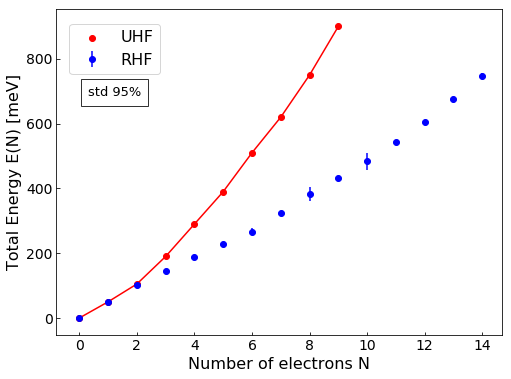

In [189]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
ax.tick_params(axis="x",direction="in",which='major',labelsize=14)
ax.tick_params(axis="y",direction="in",which='major',labelsize=14)
ax.set_xlabel('Number of electrons N',fontsize=16)
ax.set_ylabel('Total Energy E(N) [meV]',fontsize=16)

electrons = np.array([0,2,4,6,8,10,12,14])
electrons2 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
E_N_paper = np.array([0,50,105,190,290,390,510,620,750,900])

plt.errorbar(electrons2 , 11.61 * E_N, yerr = 2*np.sqrt(N_av) * 11.61 * E_Nvar, fmt='bo', label = 'RHF')
ax.scatter(electrons2[:10],E_N_paper,c='r',label = 'UHF')
ax.plot(electrons2[:10],E_N_paper,'r')
ax.legend(fontsize=16,loc = (0.03,0.8))
ax.text(0.3, 685, 'std 95%', style='normal',
        bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 7}, fontsize = 13)
plt.show()

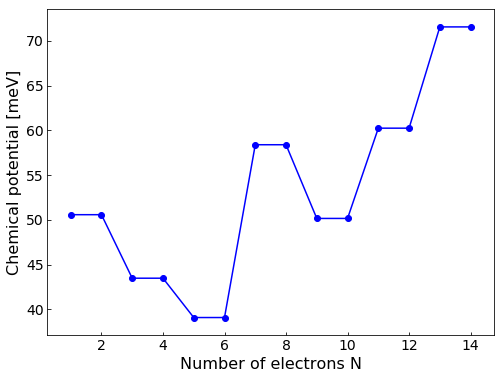

In [210]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
ax.tick_params(axis="x",direction="in",which='major',labelsize=14)
ax.tick_params(axis="y",direction="in",which='major',labelsize=14)
ax.set_xlabel('Number of electrons N',fontsize=16)
ax.set_ylabel('Chemical potential [meV]',fontsize=16)

ax.plot(electrons2[1:],11.61*mu_N,color='b')
ax.scatter(electrons2[1:],11.61*mu_N,color='b')

plt.savefig('chemical.png')
plt.show() 

Different quantum dot (increased size)

In [155]:
lz = 0.5
lx = 5

OMEGA_X = 1/lx**2
OMEGA_Z = 1/lz**2

N_electrons = 2
N_basis = 14
N_points = 100000
integrals_file = "integrals/integrals_QD_14nz0_a.npy"

normalized_wf = True

max_iter_SCF = 500
eps_SCF = 1e-4
Delta_SCF = 0

In [156]:
def analytical_1(p,q):
    n_p = index_to_q_numbers(p-1)
    I = (p==q)*(OMEGA_X*(n_p[0] + n_p[1] + 1) + OMEGA_Z*(n_p[2] + 0.5))
    
    return I
def f_cov(p, r, q, s):
    
    cov = 0.5*np.diag([1/OMEGA_X, 1/OMEGA_X, 1/OMEGA_Z, 1/OMEGA_X, 1/OMEGA_X, 1/OMEGA_Z])
    
    return cov
def Hermite_pol(x, n):
    """
    Evaluates the Hermite polynomial of order n at x.

    Parameters
    ==========
    x : float or np.ndarray
        Values in which to evaluate the Hermite polynomial
    n : int
        Oder of the Hermite polynomial

    Returns
    =======
    float or np.ndarray
    """
    return special.eval_hermite(n, x)

def HO_wf(x, n, omega=OMEGA_X):
    """
    Evaluates the n^th eigenfunction of the Harmonic Oscillator at x.
    The units of x are sqrt(hbar/m*omega). 

    Parameters
    ==========
    x : float or np.ndarray(N)
        Values in which to evaluate eigenfunction
    n : int
        Number of the eigenfunction
    omega : float
        Angular frequency of the Harmonic Oscillator

    Returns
    =======
    float or np.ndarray(N)
    """
    #return omega**0.25 * Hermite_pol(np.sqrt(omega)*x, n) * np.exp(-omega*x**2 / 2) / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi))
    return omega**0.25 * Hermite_pol(np.sqrt(omega)*x, n) / np.sqrt(2**n * np.math.factorial(n) * np.sqrt(np.pi))

def HO_wf_3D(x, y, z, nx, ny, nz, omega_x=OMEGA_X, omega_y=OMEGA_X, omega_z=OMEGA_Z):
    """
    Evaluates the n^th eigenfunction of the (anisotropic) Harmonic Oscillator at x,y,z.
    The units of x,y,z are sqrt(hbar/m*omega). 

    Parameters
    ==========
    x, y, z : float or np.ndarray(N)
        Position in which to evaluate the wave function
    nx, ny, nz : int
        Number of the eigenfunction for each cartesian coordinate
    omega_x, omega_y, omega_z : float
        Harmonic osciallation constant for each cartesian coordinate

    Returns
    =======
    float or np.ndarray(N)
    """
    return HO_wf(x, nx, omega=omega_x)*HO_wf(y, ny, omega=omega_y)*HO_wf(z, nz, omega=omega_z)

def index_to_q_numbers(k):
    """
    Returns the quantum numbers nx, ny, nz associated with the basis index k

    Parameters
    ----------
    k: int
        Index of the basis from 0 to 13

    Returns
    ----------
    nz ,ny, nz : int 
        Quantum numbers
    """

    #q_numbers = np.array([(0,0,0),(0,0,1),(0,1,0),(1,0,0),(0,1,1),(1,0,1),(1,1,0),(1,1,1),(1,1,2),(1,2,1),(2,1,1),(1,2,2),(2,1,2),(2,2,1)])
    q_numbers = np.array([(0,0,0),(0,1,0),(1,0,0),(1,1,0),(2,0,0),(0,2,0),(2,1,0),(1,2,0),(3,0,0),(0,3,0),(2,2,0),(2,2,0),(3,1,0),(1,3,0)])

    return q_numbers[k]
def integrand_2(R, p, r, q, s):
    r1 = R[:,0:3]
    r2 = R[:,3:6]
    r12 = np.sqrt(np.sum((r1 - r2)**2, axis=-1))
    
    x1 = R[:,0]
    y1 = R[:,1]
    z1 = R[:,2]
    x2 = R[:,3]
    y2 = R[:,4]
    z2 = R[:,5]
    
    n_p = index_to_q_numbers(p-1)
    n_r = index_to_q_numbers(r-1)
    n_q = index_to_q_numbers(q-1)
    n_s = index_to_q_numbers(s-1)
    
    result = 1/r12
    
    result *= HO_wf_3D(x1, y1, z1, n_p[0], n_p[1], n_p[2])
    result *= HO_wf_3D(x2, y2, z2, n_r[0], n_r[1], n_r[2])
    result *= HO_wf_3D(x1, y1, z1, n_q[0], n_q[1], n_q[2])
    result *= HO_wf_3D(x2, y2, z2, n_s[0], n_s[1], n_s[2])
  
    
    return result

def norm_product(p, r, q, s):
    return (np.pi/OMEGA_X)**2 * np.pi/OMEGA_Z

def two_body_integrand(p, r, q, s):
    f = lambda R: integrand_2(R, p, r, q, s)*norm_product(p, r, q, s)
    
    return f

In [157]:
# One- and Two-body integrals
MC_args = {"f_cov":f_cov, "f_integrand":two_body_integrand, "N_points":N_points}
integrals = lib.integral_master(N_basis)
integrals.calculate(integrals_file, analytical_1, MC_args = MC_args)

Calculating two electron integrals: 1/14
Calculating two electron integrals: 2/14
Calculating two electron integrals: 3/14
Calculating two electron integrals: 4/14
Calculating two electron integrals: 5/14
Calculating two electron integrals: 6/14
Calculating two electron integrals: 7/14
Calculating two electron integrals: 8/14
Calculating two electron integrals: 9/14
Calculating two electron integrals: 10/14
Calculating two electron integrals: 11/14
Calculating two electron integrals: 12/14
Calculating two electron integrals: 13/14
Calculating two electron integrals: 14/14


In [158]:
if not normalized_wf:
    S = np.zeros((4,4))
    for p in range(4):
        for q in range(4):
            S[p][q] = (np.pi/(ALPHA[p]+ALPHA[q]))**(1.5)
    SVAL, SVEC = np.linalg.eigh(S) 
    SVAL_minhalf = (np.diag(SVAL**(-0.5))) 
    X = np.dot(SVEC, np.dot(SVAL_minhalf, np.transpose(SVEC)))
else:
    S = np.eye(N_basis)

In [161]:
N_max = 14
N_av = 20 #times we do the SCF to do statistics
N_pairs = int(N_max/2)

E_i_a = np.zeros(N_av)
E_N_a = np.zeros(N_max + 1)
E_Nvar_a = np.zeros(N_max + 1)

for n in range(1,N_pairs +1):
    N_electrons = n*2
    print ('Computing energy for N_electrons = ', N_electrons,'\r')
    for av in range(N_av):
        E_i_a[av] = lib.SCF(N_electrons, integrals, S, max_iter_SCF, eps_SCF, print_E=False)
        
    E_N_a[N_electrons] = np.average(E_i_a)
    E_Nvar_a[N_electrons] = np.std(E_i_a)/np.sqrt(N_av)
    print('E({})='.format(N_electrons),E_N_a[N_electrons])
    
print(E_N_a)

Computing energy for N_electrons =  2 
E(2)= 4.067343852093808
Computing energy for N_electrons =  4 
E(4)= 5.996329279611082
Computing energy for N_electrons =  6 
E(6)= 8.07675198739323
Computing energy for N_electrons =  8 
E(8)= 10.145576229440753
Computing energy for N_electrons =  10 
E(10)= 12.252479552241068
Computing energy for N_electrons =  12 
E(12)= 14.404555831868734
Computing energy for N_electrons =  14 
E(14)= 16.642144388662526
[ 0.          0.          4.06734385  0.          5.99632928  0.
  8.07675199  0.         10.14557623  0.         12.25247955  0.
 14.40455583  0.         16.64214439]


In [162]:
for k in range(int(Ne_max/2)+1):
    if k != Ne_max/2:
        E_N_a[2*k+1] = (E_N_a[2*k+2] + E_N_a[2*k]) / 2

mu_N_a = np.zeros(Ne_max)
for k in range(1, Ne_max + 1):
    mu_N_a[k-1] = E_N_a[k] - E_N_a[k-1]
    
print('energies',E_N_a)
print('chemical pot', mu_N_a)

energies [ 0.          2.03367193  4.06734385  5.03183657  5.99632928  7.03654063
  8.07675199  9.11116411 10.14557623 11.19902789 12.25247955 13.32851769
 14.40455583 15.52335011 16.64214439]
chemical pot [2.03367193 2.03367193 0.96449271 0.96449271 1.04021135 1.04021135
 1.03441212 1.03441212 1.05345166 1.05345166 1.07603814 1.07603814
 1.11879428 1.11879428]


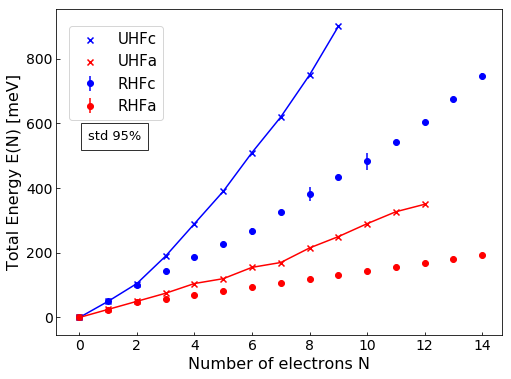

In [206]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
ax.tick_params(axis="x",direction="in",which='major',labelsize=14)
ax.tick_params(axis="y",direction="in",which='major',labelsize=14)
ax.set_xlabel('Number of electrons N',fontsize=16)
ax.set_ylabel('Total Energy E(N) [meV]',fontsize=16)

electrons = np.array([0,2,4,6,8,10,12,14])
electrons2 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
E_N_paper_a = np.array([0,25,50,75,105,120,155,170,215,250,290,327,350])

plt.errorbar(electrons2 , 11.61 * E_N, yerr = 2*np.sqrt(N_av) * 11.61 * E_Nvar, fmt='bo', label = 'RHFc')
ax.scatter(electrons2[:10],E_N_paper,c='b',label = 'UHFc',marker = 'x')
ax.plot(electrons2[:10],E_N_paper,'b')

plt.errorbar(electrons2 , 11.61 * E_N_a, yerr = 2*np.sqrt(N_av) * 11.61 * E_Nvar_a, fmt='ro', label = 'RHFa')
ax.scatter(electrons2[:13],E_N_paper_a,c='r',label = 'UHFa',marker='x')
ax.plot(electrons2[:13], E_N_paper_a, 'r')

ax.legend(fontsize=15, loc = (0.03,0.66))
ax.text(0.3,550, 'std 95%', style='normal',
        bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 7}, fontsize = 13)
plt.savefig('energias.png')
plt.show()


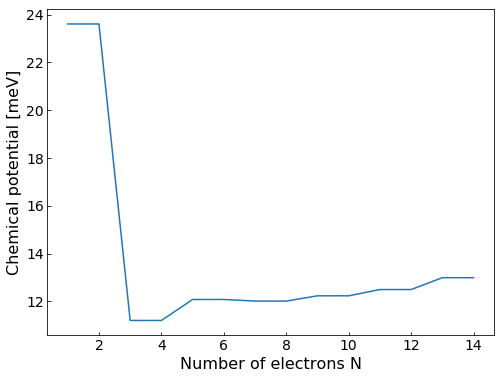

In [201]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
ax.tick_params(axis="x",direction="in",which='major',labelsize=14)
ax.tick_params(axis="y",direction="in",which='major',labelsize=14)
ax.set_xlabel('Number of electrons N',fontsize=16)
ax.set_ylabel('Chemical potential [meV]',fontsize=16)

ax.plot(electrons2[1:],11.61*mu_N_a)

plt.show() 

In [202]:
mu_N_a

array([2.03367193, 2.03367193, 0.96449271, 0.96449271, 1.04021135,
       1.04021135, 1.03441212, 1.03441212, 1.05345166, 1.05345166,
       1.07603814, 1.07603814, 1.11879428, 1.11879428])